In [1]:
import pandas as pd
import seaborn as sns
from pydci.log import enable_log, disable_log
from pydci.examples import lotka_volterra
import importlib
import itertools
from alive_progress import alive_bar
from pydci import PCAMUDProblem
from pydci.log import logger
import numpy as np
import pandas as pd

enable_log()

[11/18/23 13:08:55] INFO     Logger initialized                                                           ]8;id=651852;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=327988;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

## Code now in OSS class

In [2]:
def solve_search(
    self,
    prob_args,
    search_list,
    def_args=None,
    exp_thresh: float = 0.5,
    best_method: str = "closest",
):
    """
    Search through different iterations of solvign the PCA problem

    Thea idea of this method is, given a chunk of data, and a list of
    different iterative solve arguments, solve them and determine
    the "best" solution

    # TODO: Move this inside of Model class: self -> self

    Parameters
    ----------
    """

    am = ["closest", "min_kl", "max_kl"]
    if best_method not in am:
        msg = f"Unrecognized best method {best_method}. Allowed: {am}"
        raise ValueError(msg)
    if exp_thresh <= 0:
        msg = f"Expected ratio thresh must be a float > 0: {exp_thresh}"
        raise ValueError(msg)

    all_search_results = []
    all_results = []
    with alive_bar(
        len(search_list),
        title="Solving for different combinations",
        force_tty=True,
        receipt=True,
        length=40,
    ) as bar:
        for idx, args in enumerate(search_list):
            args.update(def_args if def_args is not None else {})

            # Solve -> Saves states in state dictionary
            prob = PCAMUDProblem(
                prob_args["samples"],
                prob_args["data"],
                self.measurement_noise,
                pi_in=prob_args["pi_in"],
            )

            try:
                prob.solve_it(**args, state_extra={"search_index": idx})
            except ZeroDivisionError or KDEError as e:
                logger.error(f"Failed: Ill-posed problem: {e}")
                continue
            except RuntimeError as r:
                if "No solution found within exp_thresh" in str(r):
                    logger.error(f"Failed: No solution in exp_thresh: {r}")
                    continue
                else:
                    raise r
            else:
                # ! What state do we need to whipe here to ensure back to original conditions of search on next iteration?
                # Store results per each iteration and final result
                # This will be erased the next iteration if we don't store it
                all_search_results.append(prob.it_results.copy())
                all_search_results[-1]["index"] = idx
                all_results.append(prob.result.copy())
                all_results[-1]["index"] = idx

            bar()

    # Parse DataFrame with results of mud estimations for each ts choice
    res_df = pd.concat(all_results)
    res_df["predict_delta"] = np.abs(res_df["e_r"] - 1.0)
    res_df["within_thresh"] = res_df["predict_delta"] <= exp_thresh
    res_df["closest"] = np.logical_and(
        res_df["predict_delta"]
        <= res_df[res_df["within_thresh"]]["predict_delta"].min(),
        res_df["within_thresh"],
    )
    res_df["max_kl"] = np.logical_and(
        res_df["kl"] >= res_df[res_df["within_thresh"]]["kl"].max(),
        res_df["within_thresh"],
    )
    res_df["min_kl"] = np.logical_and(
        res_df["kl"] <= res_df[res_df["within_thresh"]]["kl"].min(),
        res_df["within_thresh"],
    )

    # Set to best
    search_results = res_df
    all_search_results = pd.concat(
        all_search_results
    )  # Has internal iterations for each try
    result = res_df[res_df[best_method]]

    if len(result) == 0:
        raise RuntimeError(f"No solution found within exp_thresh")
    else:
        # Re-solve Using Best
        best = PCAMUDProblem(
            prob_args["samples"],
            prob_args["data"],
            self.measurement_noise,
            pi_in=prob_args["pi_in"],
        )
        best.solve_it(**search_list[result["index"].values[0]])

    return {
        "best": best,
        "search_results": search_results,
        "all_search_results": all_search_results,
    }

def parse_splits_list(config):
    splits_list = [
        {
            "pca_splits": i,
            "pca_components": config["pca_components"],
            "pca_mask": config["pca_mask"],
            "exp_thresh": config["exp_thresh"],
        }
        for i in range(1, len(range(config["pca_mask"])) % lvm.n_params)
    ]
    return splits_list


def parse_mask_list(
    mask_max, step_size=1, pca_splits=1, exp_thresh=1e20, pca_components=[[0]]
):
    mask_list = [
        {
            "pca_splits": pca_splits,
            "pca_components": pca_components,
            "pca_mask": range(i),
            "exp_thresh": exp_thresh,
        }
        for i in range(step_size, mask_max - 1, step_size)
    ]
    return mask_list


def parse_pca_list(nc, pca_splits=1, exp_thresh=1e20, pca_mask=None):
    pca_list = [
        {
            "pca_splits": pca_splits,
            "pca_components": [list(range(i + 1))],
            "pca_mask": pca_mask,
            "exp_thresh": exp_thresh,
        }
        for i in range(nc)
        if pca_mask is None or i < len(pca_mask)
    ]
    return pca_list

def get_search_combinations(
    self,
    data_idx=-1,
    exp_thresh=1e20,
):
    """ """
    if len(self.data) == 0 or data_idx > len(self.data):
        raise ValueError(f"Invalid data_idx: {data_idx}. Data length: {len(self.data)}")
    df = self.data[data_idx]
    sampled_data = df[df["sample_flag"]]
    n_data = len(sampled_data) * self.n_states
    data_chunk_size = self.n_params if self.n_params <= n_data else n_data

    # * PCA component variations -> Dependent on sample size (and # of data points if <= n_params)
    # First choose # of principle components to use.
    # Start with just doing all possible:  1->data_chunk_size.
    # TODO: Future -> Use sample size to determine how many components to use (dimenionalsity of problem)
    # * Data Mask -> What percent of total data to use
    # * Increasing chunks of data_chunk_size.
    search_list = [
        {
            "exp_thresh": exp_thresh,
            "pca_components": [list(range(i + 1))],
            "pca_mask": range(j),
            "pca_splits": k,
        }
        for i in range(data_chunk_size)
        for j in range(data_chunk_size, n_data, data_chunk_size)
        for k in range(1, (n_data + 1) % data_chunk_size + 1)
        if j / (k * data_chunk_size) >= 1.0
    ]

    return search_list


# Initialize Problem

In [3]:
# Baseline
LV_P1 = [
    1.0,  # alpha - prey growth rate
    0.02,  # beta - prey death rate
    0.01,  # delta - predator growth rate
    1.0,  # gamma - predator death rate
]

LV_PARAM_MINS = 4 * [0.0]
LV_STATE_MINS = 5.0

lvm = lotka_volterra.LotkaVolterraModel(
    x0=[100, 10],
    lam_true=LV_P1,
    solve_ts=0.01,
    measurement_noise=1,
    sample_ts=0.5
)

# lvm = lotka_volterra.LotkaVolterraModel(sample_ts=0.5)

# First Iteration

In [4]:
lvm.get_data(tf=2.0)
pi_in, samples = lvm.get_uniform_initial_samples(num_samples=1000, scale=0.5)
f_res_1 = lvm.forward_solve(samples=samples)

[11/18/23 13:08:57] INFO     Getting data for model from 0.0 to 2.0                                    ]8;id=530668;file:///Users/cnegrete/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=260000;file:///Users/cnegrete/repos/pyDCI/src/pydci/Model.py#389\389]8;;\

                    INFO     Drawing 1000 from uniform at:                                             ]8;id=947640;file:///Users/cnegrete/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=721070;file:///Users/cnegrete/repos/pyDCI/src/pydci/Model.py#584\584]8;;\
                                     loc: [0.5   0.01  0.005 0.5  ]                                                
                                     scale: [1.   0.02 0.01 1.  ]                                                  

                    INFO     Beginning forward solve from 0.0 to 2.0                                   ]8;id=727145;file:///Users/cnegrete/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=402765;file:///Users/cnegrete/repos/pyDCI/src/pydci/Model.py#457\457]8;;\

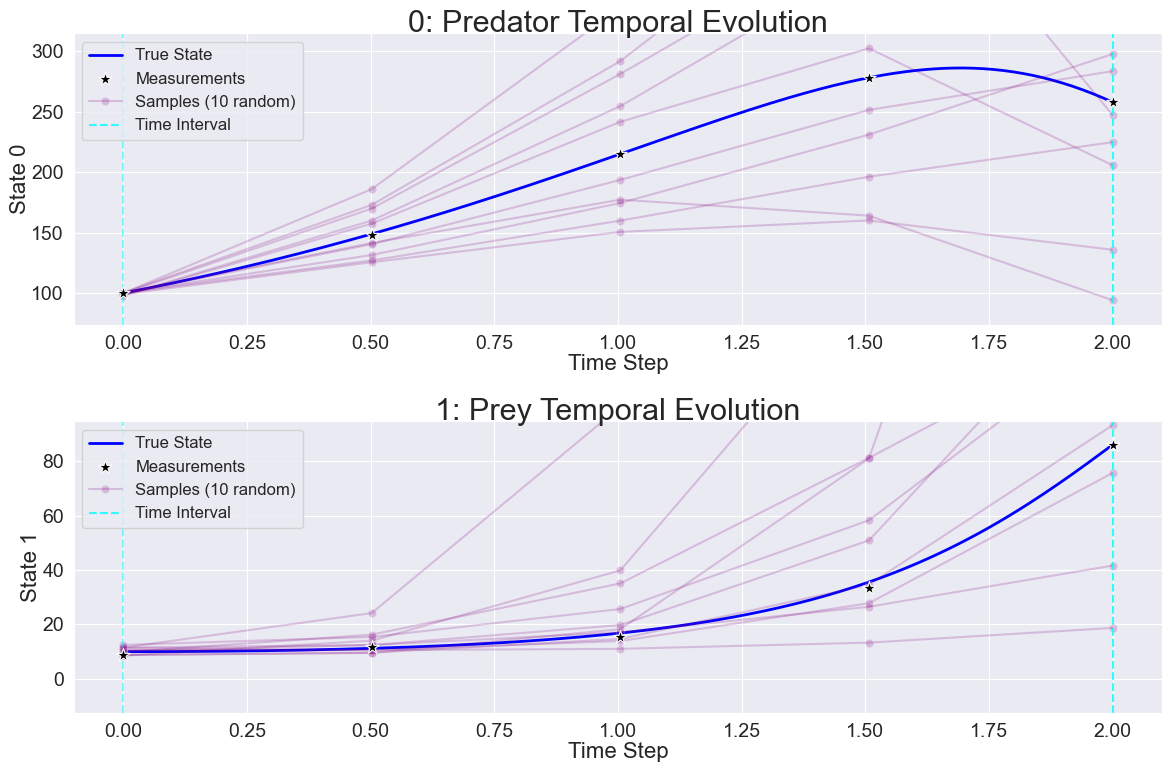

In [5]:
lvm.plot_states()

In [7]:
lvm.data[0].dropna()

,ts,shift_idx,sample_flag,lam_true_0,q_lam_true_0,q_lam_true_1,q_lam_obs_0,q_lam_obs_1
0,0.000000,0,True,1.0,100.000000,10.000000,99.981534,8.655130
50,0.502513,0,True,1.0,148.904846,11.222870,148.284630,11.654404
100,1.005025,0,True,1.0,214.970042,16.840001,215.204761,15.325033
150,1.507538,0,True,1.0,278.033088,35.600044,277.801524,33.297809
199,2.000000,0,True,1.0,257.850151,86.056007,257.543988,85.877989


In [6]:
from pydci import OfflineSequentialSearch
from pydci.log import enable_log, disable_log

enable_log(level='INFO')

oss = OfflineSequentialSearch(lvm.samples[0], lvm.data[0], lvm.measurement_noise, pi_in=pi_in)
oss.solve(max_nc=3, best_method='max_kl', data_chunk_size=2, all_data=False)

[10/31/23 01:36:26] INFO     Logger initialized                                                           ]8;id=169599;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=998277;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                    INFO     Searching through combinations:                         ]8;id=607708;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=208536;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                  exp_thresh  pca_components                                                       
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10               1                    (0,                                
                             1)           1                                                                        
                             1  1.000000e+10               1              (0, 1, 2,                                
                             3)           1                                                                        
                             2  1.000000e+10               1              (0, 1, 2,                                
                             3)           2                                                                        
                             3  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           1                                                                        
                             4  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           2                                                                        
                             5  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           3                                                                        
                             6  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           1                                                                        
                             7  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           2                                                                        
                             8  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           3                                                                        
                             9  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           4                                                                        

Solving for different combinations |                                        | ▁▃

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=730918;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=679246;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 2), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=359965;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=684414;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=525620;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=937800;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=471355;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=893500;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=515229;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=729265;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=281610;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=847159;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=862945;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=127016;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=612918;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=615572;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████                                | ▂▄

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=559402;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=697172;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 6), [0])                 ]8;id=57759;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=794203;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████                            | ▃▅

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=441706;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=808941;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=445058;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=765633;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=970304;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=979616;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=335832;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=723376;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=417636;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=625556;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=123536;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=782558;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████                    | ▄▆

                    INFO     Updating weights                                              ]8;id=932959;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=971091;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=243009;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=242176;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=387977;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=492855;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=474186;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=903821;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=499895;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=538304;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=998992;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=910988;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████                | ▅▇

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=988914;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=870556;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=497001;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=529398;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=652200;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=306397;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=826368;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=811437;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████            | ▆█

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=952486;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=951144;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=496137;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=757787;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=557078;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=306974;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=314119;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=306880;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | ▇▇

[10/31/23 01:36:27] INFO     Updating weights                                              ]8;id=364416;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=313268;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 8), [0])                 ]8;id=929200;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=500436;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=643986;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=629758;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 4, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=869794;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=396759;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=42609;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=552674;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=919063;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=903269;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | █▆

                    INFO     Updating weights                                              ]8;id=741640;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=60948;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=289351;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=641234;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=56782;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=400424;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(6, 8), [0])                 ]8;id=113766;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=186837;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

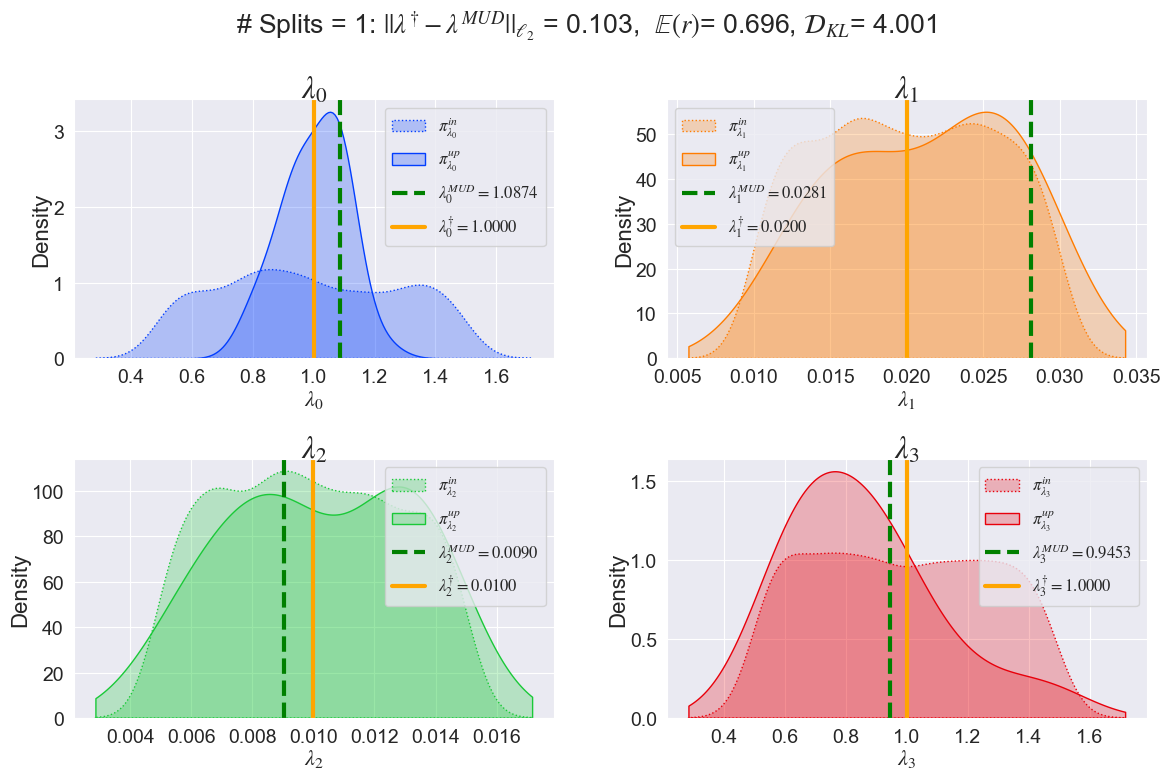

In [7]:
oss.best.param_density_plots(lam_true=np.array(LV_P1))

# Second Iteration

In [8]:
# samples_2 = search_res_1["best"].sample_dist(num_samples=100, dist="pi_up")
lvm.get_data(tf=4.0)
samples_2 = oss.best.sample_dist(num_samples=1000, dist="pi_up")
lvm.forward_solve(samples=samples_2)

[10/31/23 01:36:28] INFO     Getting data for model from 2.0 to 4.0                                    ]8;id=732870;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=755697;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py#389\389]8;;\

                    INFO     Beginning forward solve from 2.0 to 4.0                                   ]8;id=336744;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=313743;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py#457\457]8;;\

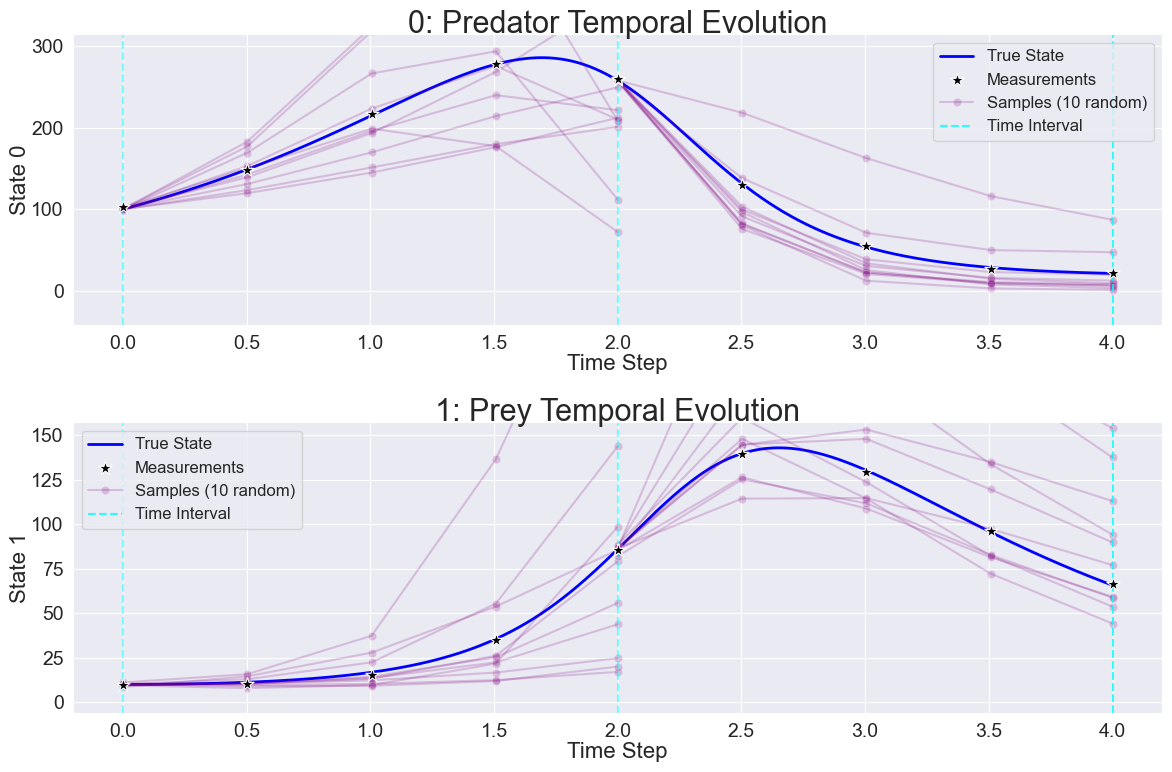

In [9]:
lvm.plot_states()

In [10]:
enable_log(level='INFO')

oss2 = OfflineSequentialSearch(lvm.samples[1], lvm.data[1], lvm.measurement_noise, pi_in=oss.best.dists['pi_up'])
oss2.solve(max_nc=2, best_method='max_kl', data_chunk_size=2, all_data=False)

[10/31/23 01:36:29] INFO     Logger initialized                                                           ]8;id=365975;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=427800;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                    INFO     Searching through combinations:                         ]8;id=622370;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=122123;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                  exp_thresh  pca_components                                                       
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10               1                    (0,                                
                             1)           1                                                                        
                             1  1.000000e+10               1              (0, 1, 2,                                
                             3)           1                                                                        
                             2  1.000000e+10               1              (0, 1, 2,                                
                             3)           2                                                                        
                             3  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           1                                                                        
                             4  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           2                                                                        
                             5  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           3                                                                        
                             6  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           1                                                                        
                             7  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           2                                                                        
                             8  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           3                                                                        
                             9  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           4                                                                        

Solving for different combinations |                                        | ▁▃

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=548353;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=794415;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 2), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=925275;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=84711;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=408038;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=32634;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=107722;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=423869;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=988764;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=404087;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=46104;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=348395;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████                                | ▂▄

                    INFO     Updating weights                                              ]8;id=4081;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=404356;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=920584;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=47115;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=701054;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=771855;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 6), [0])                 ]8;id=452916;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=385440;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████                            | ▃▅

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=793370;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=624233;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=707587;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=759392;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=246994;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=35963;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=831815;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=995556;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████                        | ▄▆

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=509765;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=468724;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=999617;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=119188;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=718898;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=369146;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=429740;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=510010;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████                    | ▅▇

                    INFO     Updating weights                                              ]8;id=800274;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=237931;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=255449;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=308309;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    ERROR    (range(4, 6): [0]): Predictabiltiy assumption violated            ]8;id=54986;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=181373;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 3:                                        ]8;id=793000;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=977451;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 5/1000 samples                                            

                    ERROR    Failed 5 with args {'exp_thresh': 10000000000.0,        ]8;id=704980;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=998422;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 6),                                         
                             'pca_splits': 3, 'fail_on_partial': True}                                             

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=167086;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=99629;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=812176;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=569125;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████                | ▆█

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=759897;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=208852;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=124219;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=862526;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=441071;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=257747;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=372741;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=318454;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    ERROR    (range(4, 8): [0]): Predictabiltiy assumption violated            ]8;id=425686;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=447090;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 2:                                        ]8;id=470824;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=10128;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 2/1000 samples                                            

                    ERROR    Failed 7 with args {'exp_thresh': 10000000000.0,        ]8;id=556898;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=829234;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 8),                                         
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=646405;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=290663;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=398852;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=998681;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | ▇▇

                    INFO     Updating weights                                              ]8;id=806855;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=400774;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=651012;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=114133;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=158671;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=349951;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 8), [0])                 ]8;id=770064;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=26078;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | █▆

                    ERROR    (range(6, 8): [0]): Predictabiltiy assumption violated            ]8;id=158746;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=274736;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 3:                                        ]8;id=616916;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=211723;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 5/1000 samples                                            

                    ERROR    Failed 8 with args {'exp_thresh': 10000000000.0,        ]8;id=840234;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=201988;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 8),                                         
                             'pca_splits': 3, 'fail_on_partial': True}                                             

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=718750;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=665390;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 4, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=775669;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=474422;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=684057;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=505601;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=764786;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=495248;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▇▅

[10/31/23 01:36:30] INFO     Updating weights                                              ]8;id=688533;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=26018;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=983922;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=346163;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▆▄

                    ERROR    (range(4, 6): [0]): Predictabiltiy assumption violated            ]8;id=714631;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=551220;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 3:                                        ]8;id=997653;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=188376;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 5/1000 samples                                            

                    ERROR    Failed 9 with args {'exp_thresh': 10000000000.0,        ]8;id=217340;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=163874;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 8),                                         
                             'pca_splits': 4, 'fail_on_partial': True}                                             

In [11]:
oss2.results

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,pca_mask,i,I,search_index,predict_delta,within_thresh,valid,closest,max_kl,min_kl
0,0.921824,0.767142,1.000,1.000,True,None,1.022109,0.025591,0.009296,0.835348,...,"range(0, 2)",1,1,0,0.078176,True,True,False,False,True
0,0.849991,3.104432,1.000,0.171,True,None,0.975062,0.022704,0.007424,0.961292,...,"range(0, 4)",1,1,1,0.150009,True,True,False,False,False
0,0.622446,3.195832,1.000,0.120,True,None,0.941072,0.019576,0.008469,0.922042,...,"range(2, 4)",2,2,2,0.377554,True,True,False,False,False
0,1.084890,3.491566,1.000,0.081,True,None,1.048621,0.022483,0.006291,0.518006,...,"range(0, 6)",1,1,3,0.084890,True,True,False,True,False
0,0.547800,2.983054,0.181,0.013,True,None,1.096368,0.022600,0.004790,0.186774,...,"range(3, 6)",2,2,4,0.452200,True,True,False,False,False
0,NaN,2.383739,0.120,0.056,False,Failed on iteration 3:\nObsered/Predicted = In...,0.941072,0.019576,0.008469,0.922042,...,"range(2, 4)",3,3,5,NaN,False,False,False,False,False
0,1.067933,3.457334,1.000,0.087,True,None,1.029843,0.022346,0.007526,0.760521,...,"range(0, 8)",1,1,6,0.067933,True,True,True,False,False
0,NaN,2.809737,0.171,0.036,False,Failed on iteration 2:\nObsered/Predicted = In...,0.975062,0.022704,0.007424,0.961292,...,"range(0, 4)",2,2,7,NaN,False,False,False,False,False
0,NaN,3.258216,0.013,0.002,False,Failed on iteration 3:\nObsered/Predicted = In...,1.096368,0.022600,0.004790,0.186774,...,"range(3, 6)",3,3,8,NaN,False,False,False,False,False
0,NaN,2.383739,0.120,0.056,False,Failed on iteration 3:\nObsered/Predicted = In...,0.941072,0.019576,0.008469,0.922042,...,"range(2, 4)",3,4,9,NaN,False,False,False,False,False


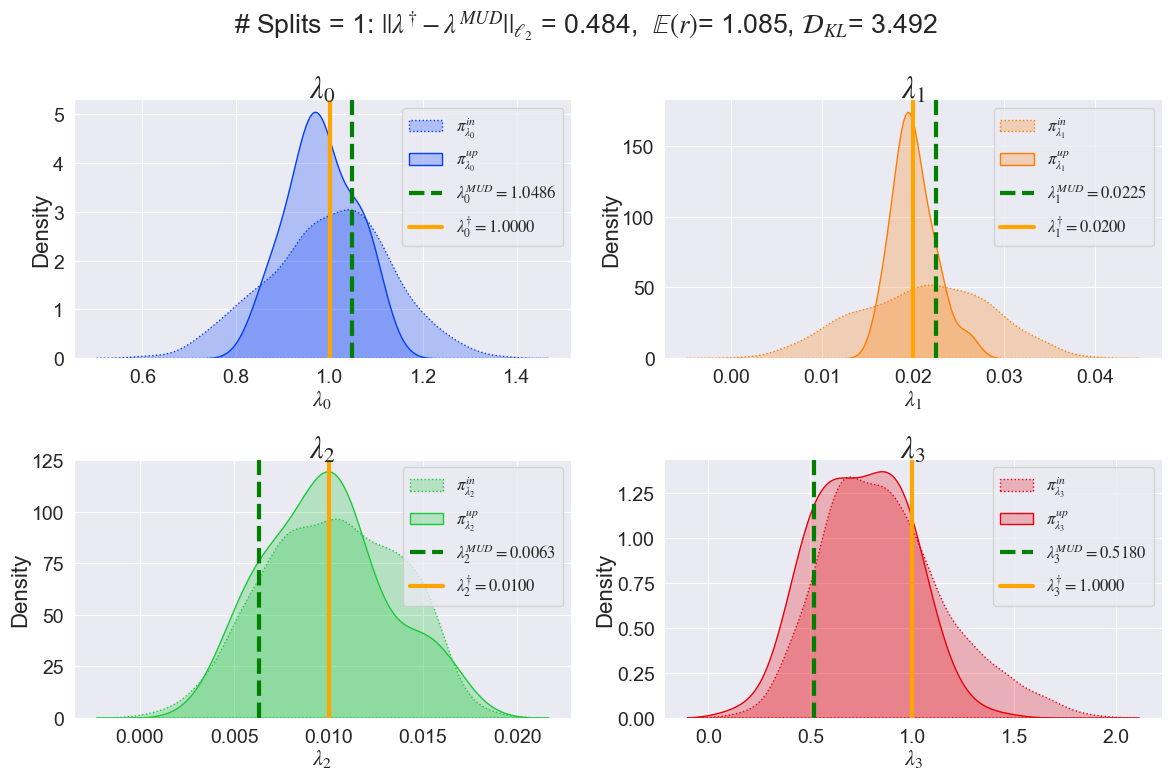

In [12]:
oss2.best.param_density_plots(lam_true=np.array(LV_P1))

# Third Iteration

In [13]:
# samples_2 = search_res_1["best"].sample_dist(num_samples=100, dist="pi_up")
lvm.get_data(tf=6.0)
samples_3 = oss2.best.sample_dist(num_samples=1000, dist="pi_up")
lvm.forward_solve(samples=samples_3)

[10/31/23 01:36:31] INFO     Getting data for model from 4.0 to 6.0                                    ]8;id=3087;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=716135;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py#389\389]8;;\

                    INFO     Beginning forward solve from 4.0 to 6.0                                   ]8;id=536274;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=12922;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py#457\457]8;;\

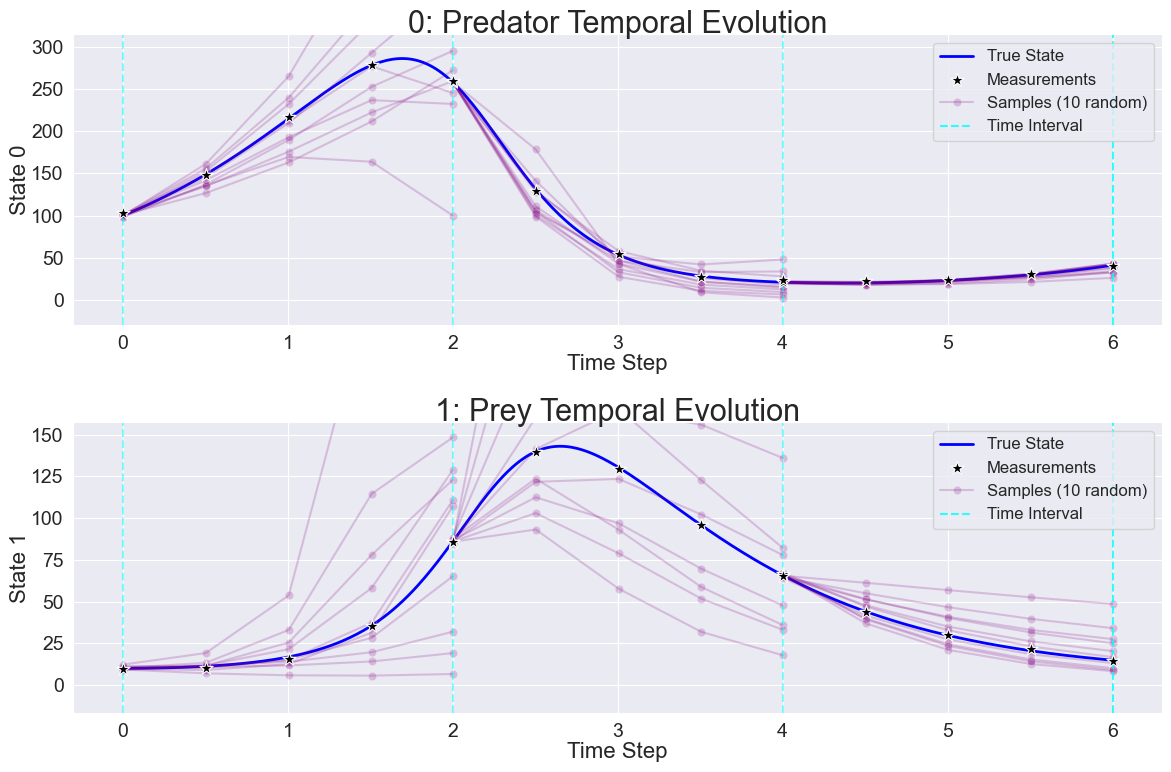

In [14]:
lvm.plot_states()

In [15]:
enable_log(level='INFO')

oss3 = OfflineSequentialSearch(lvm.samples[2], lvm.data[2], lvm.measurement_noise, pi_in=oss2.best.dists['pi_up'])
oss3.solve(max_nc=2, best_method='max_kl', data_chunk_size=2, all_data=False)

[10/31/23 01:37:49] INFO     Logger initialized                                                           ]8;id=382938;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=551864;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                    INFO     Searching through combinations:                         ]8;id=632850;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=905072;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                  exp_thresh  pca_components                                                       
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10               1                    (0,                                
                             1)           1                                                                        
                             1  1.000000e+10               1              (0, 1, 2,                                
                             3)           1                                                                        
                             2  1.000000e+10               1              (0, 1, 2,                                
                             3)           2                                                                        
                             3  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           1                                                                        
                             4  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           2                                                                        
                             5  1.000000e+10               1        (0, 1, 2, 3, 4,                                
                             5)           3                                                                        
                             6  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           1                                                                        
                             7  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           2                                                                        
                             8  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           3                                                                        
                             9  1.000000e+10               1  (0, 1, 2, 3, 4, 5, 6,                                
                             7)           4                                                                        

Solving for different combinations |                                        | ▁▃

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=992834;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=806432;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 2), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=885660;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=594752;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=914866;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=671077;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=921293;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=269251;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████                                    | ▂▄

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=575445;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=683953;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=143273;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=566020;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=493199;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=17225;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=604906;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=387140;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████                                | ▃▅

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=609368;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=391546;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 6), [0])                 ]8;id=314812;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=421882;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████                            | ▄▆

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=916062;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=338696;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=833656;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=236590;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████                        | ▅▇

                    INFO     Updating weights                                              ]8;id=737208;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=305684;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=19140;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=56729;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=196720;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=544333;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=52759;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=225565;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████                    | ▆█

                    INFO     Updating weights                                              ]8;id=521176;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=889104;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=762714;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=954567;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=853132;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=144455;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=637407;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=534094;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████                    | ▇▇

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=559570;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=128435;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=639408;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=595005;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

[10/31/23 01:37:50] INFO     Attempting solve with args: {'exp_thresh':              ]8;id=116733;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=417555;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=41237;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=172834;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████            | █▆

                    INFO     Updating weights                                              ]8;id=346370;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=296689;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=830654;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=264735;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | ▇▅

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=263713;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=86081;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=958408;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=727432;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=952716;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=406109;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=9025;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=430192;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | ▆▄

                    INFO     Updating weights                                              ]8;id=783171;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=773011;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 8), [0])                 ]8;id=750746;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=636938;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | ▅▃

                    ERROR    (range(6, 8): [0]): Predictabiltiy assumption violated            ]8;id=695583;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=950370;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 3:                                        ]8;id=287619;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=540043;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 1/1000 samples                                            

                    ERROR    Failed 8 with args {'exp_thresh': 10000000000.0,        ]8;id=281834;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=599661;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 8),                                         
                             'pca_splits': 3, 'fail_on_partial': True}                                             

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=548835;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=860900;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 4, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=243976;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=177305;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▄▂

                    INFO     Updating weights                                              ]8;id=482063;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=590299;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=402685;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=273624;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▃▁

                    INFO     Updating weights                                              ]8;id=488835;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=456052;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=655007;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=612307;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=517013;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=712446;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(6, 8), [0])                 ]8;id=748553;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=849934;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▂▂

                    ERROR    (range(6, 8): [0]): Predictabiltiy assumption violated            ]8;id=665537;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=773868;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 4:                                        ]8;id=965859;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=909179;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 1/1000 samples                                            

                    ERROR    Failed 9 with args {'exp_thresh': 10000000000.0,        ]8;id=474496;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=633309;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 8),                                         
                             'pca_splits': 4, 'fail_on_partial': True}                                             

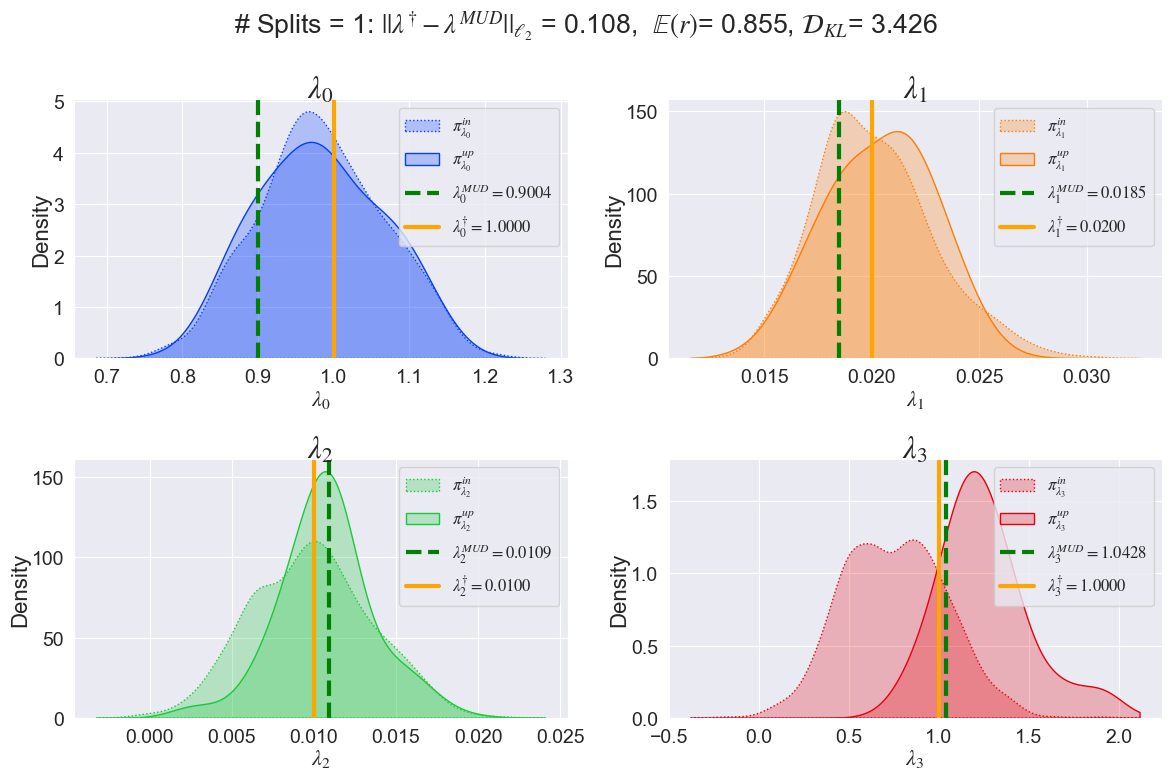

In [17]:
oss3.best.param_density_plots(lam_true=np.array(LV_P1))

# Final Samples

[10/31/23 01:42:37] INFO     Getting data for model from 6.0 to 12.0                                   ]8;id=804716;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=624153;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py#389\389]8;;\

                    INFO     Beginning forward solve from 6.0 to 12.0                                  ]8;id=985581;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=425800;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/Model.py#457\457]8;;\

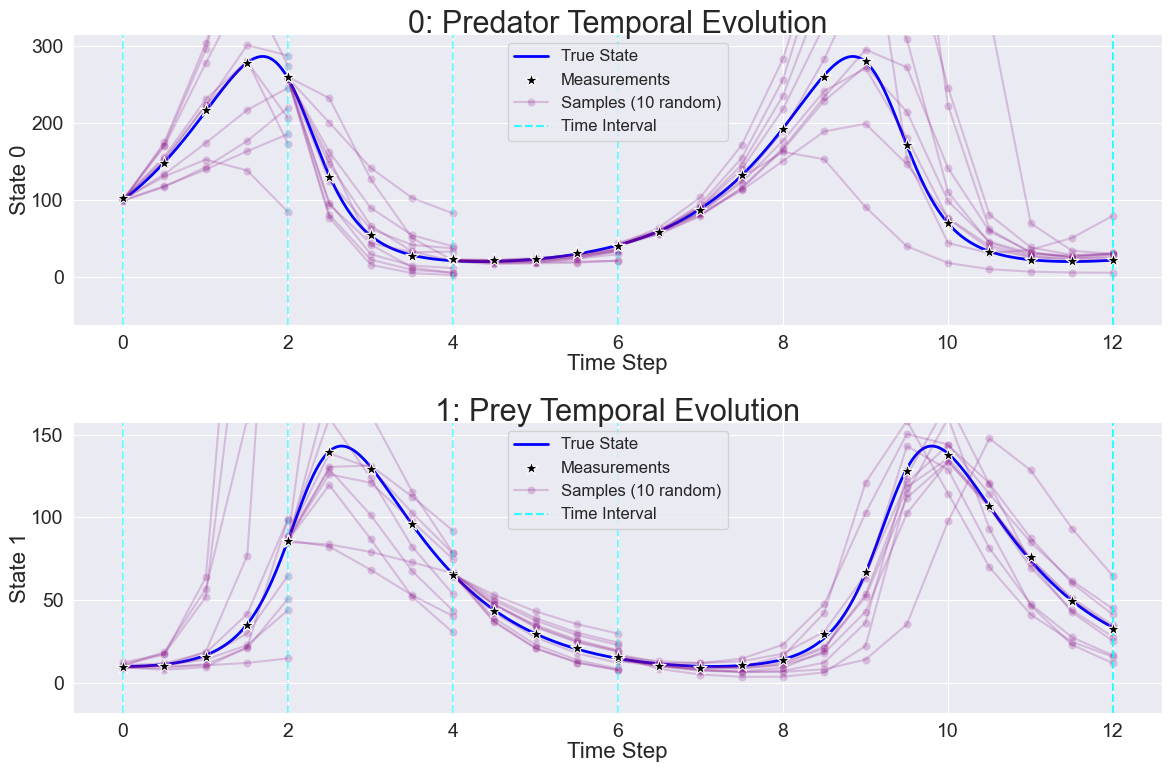

In [18]:
lvm.get_data(tf=12.0)
samples_4 = oss3.best.sample_dist(num_samples=1000, dist="pi_up")
lvm.forward_solve(samples=samples_4)

lvm.plot_states()

In [29]:
enable_log(level='INFO')

oss4 = OfflineSequentialSearch(lvm.samples[3], lvm.data[3], lvm.measurement_noise, pi_in=oss3.best.dists['pi_up'])
oss4.solve(max_nc=4, best_method='max_kl', data_chunk_size=2, all_data=False)

[10/31/23 01:55:38] INFO     Logger initialized                                                           ]8;id=300025;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=394694;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                    INFO     Searching through combinations:                         ]8;id=935562;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=96673;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                   exp_thresh  pca_components                                                      
                             pca_mask  \                                                                           
                             0   1.000000e+10               1                                                      
                             (0, 1)                                                                                
                             1   1.000000e+10               1                                                      
                             (0, 1, 2, 3)                                                                          
                             2   1.000000e+10               1                                                      
                             (0, 1, 2, 3)                                                                          
                             3   1.000000e+10               1                                                      
                             (0, 1, 2, 3, 4, 5)                                                                    
                             4   1.000000e+10               1                                                      
                             (0, 1, 2, 3, 4, 5)                                                                    
                             5   1.000000e+10               1                                                      
                             (0, 1, 2, 3, 4, 5)                                                                    
                             6   1.000000e+10               1                (0, 1,                                
                             2, 3, 4, 5, 6, 7)                                                                     
                             7   1.000000e+10               1                (0, 1,                                
                             2, 3, 4, 5, 6, 7)                                                                     
                             8   1.000000e+10               1                (0, 1,                                
                             2, 3, 4, 5, 6, 7)                                                                     
                             9   1.000000e+10               1                (0, 1,                                
                             2, 3, 4, 5, 6, 7)                                                                     
                             10  1.000000e+10               1          (0, 1, 2, 3,                                
                             4, 5, 6, 7, 8, 9)                                                                     
                             11  1.000000e+10               1          (0, 1, 2, 3,                                
                             4, 5, 6, 7, 8, 9)                                                                     
                             12  1.000000e+10               1          (0, 1, 2, 3,                                
                             4, 5, 6, 7, 8, 9)                                                                     
                             13  1.000000e+10               1          (0, 1, 2, 3,                                
                             4, 5, 6, 7, 8, 9)                                                                     
                             14  1.000000e+10               1          (0, 1, 2, 3,                                
                             4, 5, 6, 7, 8, 9)           

Solving for different combinations |                                        | ▁▃

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=520893;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=771001;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 2), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=119324;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=815213;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=723556;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=193176;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=866309;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=988672;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=927445;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=218067;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 4), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=272239;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=848893;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████                                    | ▃▅

                    INFO     Updating weights                                              ]8;id=663451;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=881054;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=401652;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=595081;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=926767;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=61127;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 1, 'fail_on_partial': True}                                

Solving for different combinations |██████                                  | ▄▆

                    INFO     Iteration 0: Solving using (range(0, 6), [0])                 ]8;id=273787;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=526913;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=164456;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=196553;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=648353;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=985847;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████                                | ▅▇

                    INFO     Updating weights                                              ]8;id=856267;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=966240;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=687631;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=703818;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████                                | ▆█

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=363048;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=280172;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 6), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=447275;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=707722;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

[10/31/23 01:55:39] INFO     Updating weights                                              ]8;id=710021;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=765988;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=379765;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=288250;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████                              | ▇▇

                    INFO     Updating weights                                              ]8;id=613711;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=162764;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=843919;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=111775;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=501098;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=437803;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 1, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=290276;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=862494;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████                            | █▆

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=952065;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=960002;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 2, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=391744;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=820300;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=279243;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=823499;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=657928;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=270967;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████                          | ▇▅

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=411394;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=883824;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 3, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=588154;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=162029;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=151473;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=473115;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=114815;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=67186;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████                        | ▆▄

                    INFO     Updating weights                                              ]8;id=734521;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=344087;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 8), [0])                 ]8;id=233590;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=166320;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████                        | ▄▂

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=957781;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=880387;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 8), 'pca_splits': 4, 'fail_on_partial': True}                                

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=518915;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=401740;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=906989;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=134186;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=90798;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=317305;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████                      | ▃▁

                    INFO     Updating weights                                              ]8;id=550238;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=820232;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=246962;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=344114;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=948256;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=858610;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(6, 8), [0])                 ]8;id=130231;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=237236;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████                      | ▂▂

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=763898;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=171430;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 10), 'pca_splits': 1, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 10), [0])                ]8;id=364939;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=733031;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=358639;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=576876;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 10), 'pca_splits': 2, 'fail_on_partial': True}                               

Solving for different combinations |██████████████████████                  | ▁▃

                    INFO     Iteration 0: Solving using (range(0, 5), [0])                 ]8;id=783451;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=688157;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=700788;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=876057;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(5, 10), [0])                ]8;id=107271;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=914605;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████                  | ▂▄

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=997714;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=956987;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 10), 'pca_splits': 3, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=972451;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=826070;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=942693;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=488603;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(4, 7), [0])                 ]8;id=875732;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=617255;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████                | ▃▅

[10/31/23 01:55:40] INFO     Updating weights                                              ]8;id=820527;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=700964;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(7, 10), [0])                ]8;id=978622;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=768120;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████                | ▄▆

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=705801;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=934238;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 10), 'pca_splits': 4, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=390258;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=227340;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=223532;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=575662;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=660311;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=995053;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████████              | ▅▇

                    INFO     Updating weights                                              ]8;id=969353;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=804149;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 8), [0])                 ]8;id=714157;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=76127;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=346709;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=825142;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(8, 10), [0])                ]8;id=343106;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=797950;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████████              | ▆█

                    ERROR    (range(8, 10): [0]): Predictabiltiy assumption violated           ]8;id=166761;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=327883;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 4:                                        ]8;id=892631;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=931243;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 1/1000 samples                                            

                    ERROR    Failed 13 with args {'exp_thresh': 10000000000.0,       ]8;id=435245;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=160013;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 10),                                        
                             'pca_splits': 4, 'fail_on_partial': True}                                             

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=417245;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=3603;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 10), 'pca_splits': 5, 'fail_on_partial': True}                               

Solving for different combinations |████████████████████████████            | ▇▇

                    INFO     Iteration 0: Solving using (range(0, 2), [0])                 ]8;id=530647;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=227393;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=948141;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=173717;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(2, 4), [0])                 ]8;id=644449;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=564230;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=793085;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=250976;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(4, 6), [0])                 ]8;id=894061;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=976206;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████            | █▆

                    INFO     Updating weights                                              ]8;id=286582;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=51035;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(6, 8), [0])                 ]8;id=430586;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=618983;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=517210;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=617209;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

Solving for different combinations |████████████████████████████            | ▇▅

                    INFO     Iteration 4: Solving using (range(8, 10), [0])                ]8;id=295351;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=769475;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    ERROR    (range(8, 10): [0]): Predictabiltiy assumption violated           ]8;id=593596;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=517323;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

                    ERROR    Failed on iteration 5:                                        ]8;id=36833;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=822221;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 1/1000 samples                                            

                    ERROR    Failed 14 with args {'exp_thresh': 10000000000.0,       ]8;id=676819;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=367927;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 10),                                        
                             'pca_splits': 5, 'fail_on_partial': True}                                             

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=297868;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=728335;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 12), 'pca_splits': 1, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 12), [0])                ]8;id=534251;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=264546;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████████████          | ▆▄

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=389401;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=687507;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 12), 'pca_splits': 2, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 6), [0])                 ]8;id=862020;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=27763;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=532400;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=164753;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(6, 12), [0])                ]8;id=550328;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=730733;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████        | ▅▃

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=600166;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=949411;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 12), 'pca_splits': 3, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=552859;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=688755;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████████████████      | ▄▂

                    INFO     Updating weights                                              ]8;id=743468;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=949652;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=297803;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=728111;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████████████████      | ▃▁

[10/31/23 01:55:41] INFO     Updating weights                                              ]8;id=643374;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=185424;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(8, 12), [0])                ]8;id=854957;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=197177;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=923969;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=414715;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 12), 'pca_splits': 4, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=214579;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=756957;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▂▂

                    INFO     Updating weights                                              ]8;id=451599;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=362006;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=994499;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=918560;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=520793;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=313618;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 9), [0])                 ]8;id=695811;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=303481;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=5704;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=630530;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(9, 12), [0])                ]8;id=615407;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=264816;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |████████████████████████████████████    | ▁▃

                    INFO     Attempting solve with args: {'exp_thresh':              ]8;id=461316;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=844074;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#197\197]8;;\
                             10000000000.0, 'pca_components': 1, 'pca_mask':                                       
                             range(0, 12), 'pca_splits': 5, 'fail_on_partial': True}                               

                    INFO     Iteration 0: Solving using (range(0, 3), [0])                 ]8;id=12642;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=668713;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=46546;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=462694;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 1: Solving using (range(3, 6), [0])                 ]8;id=662846;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=57291;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    INFO     Updating weights                                              ]8;id=773236;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=417837;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 2: Solving using (range(6, 8), [0])                 ]8;id=677985;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=451627;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

Solving for different combinations |██████████████████████████████████████  | ▂▄

                    INFO     Updating weights                                              ]8;id=286699;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=856386;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#201\201]8;;\

                    INFO     Iteration 3: Solving using (range(8, 10), [0])                ]8;id=453740;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=177206;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#156\156]8;;\

                    ERROR    (range(8, 10): [0]): Predictabiltiy assumption violated           ]8;id=284986;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=739041;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#198\198]8;;\

Solving for different combinations |██████████████████████████████████████  | ▃▅

                    ERROR    Failed on iteration 4:                                        ]8;id=813625;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=768359;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#210\210]8;;\
                             Obsered/Predicted = Inf for 1/1000 samples                                            

                    ERROR    Failed 19 with args {'exp_thresh': 10000000000.0,       ]8;id=5002;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=438093;file:///Volumes/DataDrive/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#201\201]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 12),                                        
                             'pca_splits': 5, 'fail_on_partial': True}                                             

In [30]:
oss4.results

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,pca_mask,i,I,search_index,predict_delta,within_thresh,valid,closest,max_kl,min_kl
0,0.998446,0.007097,1.000,1.000,True,None,0.918812,0.019482,0.010625,1.201765,...,"range(0, 2)",1,1,0,0.001554,True,True,True,False,True
0,1.029490,0.326300,1.000,0.997,True,None,0.953730,0.019548,0.010759,1.125609,...,"range(0, 4)",1,1,1,0.029490,True,True,False,False,False
0,1.022773,0.367226,1.000,0.996,True,None,0.918812,0.019482,0.010625,1.201765,...,"range(2, 4)",2,2,2,0.022773,True,True,False,False,False
0,1.028546,1.168455,1.000,0.685,True,None,0.953730,0.019548,0.010759,1.125609,...,"range(0, 6)",1,1,3,0.028546,True,True,False,False,False
0,1.111145,0.721969,0.995,0.755,True,None,0.953730,0.019548,0.010759,1.125609,...,"range(3, 6)",2,2,4,0.111145,True,True,False,False,False
0,1.028491,0.768998,0.996,0.663,True,None,0.953730,0.019548,0.010759,1.125609,...,"range(4, 6)",3,3,5,0.028491,True,True,False,False,False
0,1.008415,1.944763,1.000,0.355,True,None,0.918812,0.019482,0.010625,1.201765,...,"range(0, 8)",1,1,6,0.008415,True,True,False,False,False
0,1.042027,1.690421,0.997,0.319,True,None,0.973766,0.021016,0.008295,1.070545,...,"range(4, 8)",2,2,7,0.042027,True,True,False,False,False
0,1.068702,1.045092,0.755,0.328,True,None,0.973766,0.021016,0.008295,1.070545,...,"range(6, 8)",3,3,8,0.068702,True,True,False,False,False
0,1.060869,0.831189,0.663,0.330,True,None,0.955629,0.020302,0.008882,1.101151,...,"range(6, 8)",4,4,9,0.060869,True,True,False,False,False


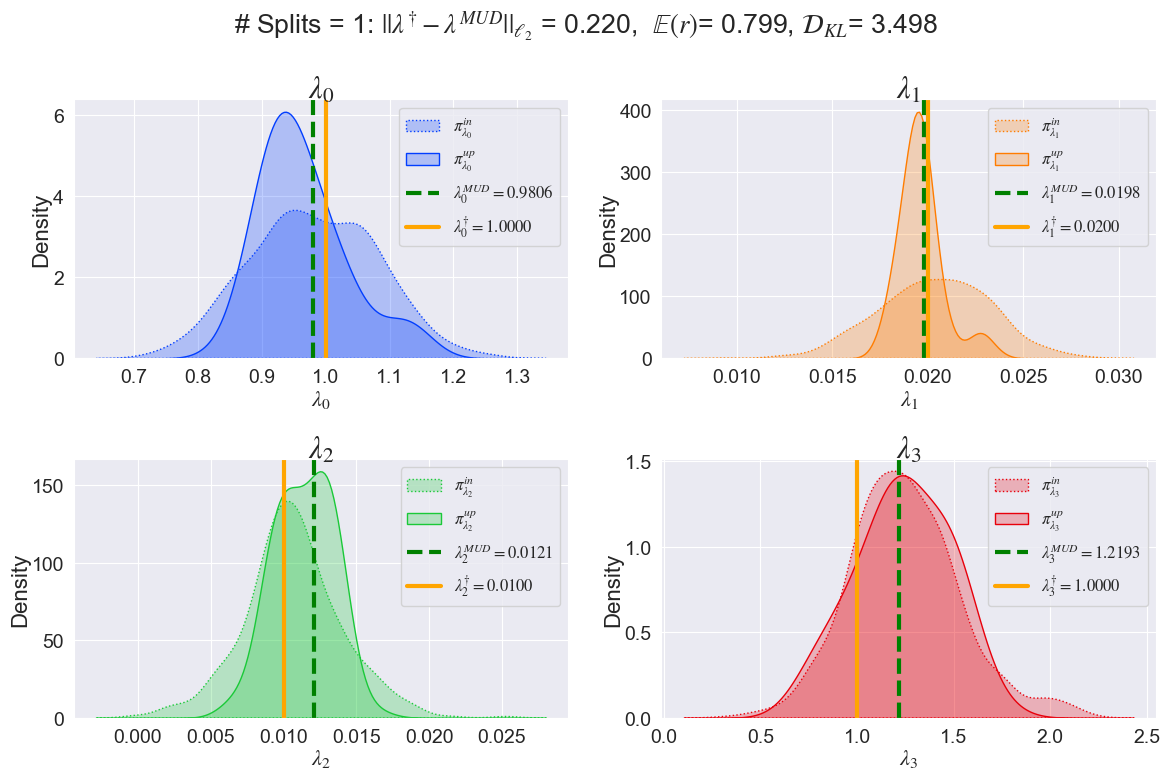

In [31]:
oss4.best.param_density_plots(lam_true=np.array(LV_P1))